# Convolutional Neural Networks (CNN)

This time we will create a CNN for the MNIST dataset ones again.



## Import libraries - Prepare the Dataset

In [ ]:
!pip install opendatasets

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

#"username":"giorgospapadakis227",
#"key":"0d98fada57d63e3b60481c013c67e993"

import opendatasets as od

username = "giorgospapadakis227"
key = "0d98fada57d63e3b60481c013c67e993"

od.download("https://www.kaggle.com/competitions/digit-recognizer/data", force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: giorgospapadakis227
Your Kaggle Key: ··········


100%|██████████| 15.3M/15.3M [00:00<00:00, 110MB/s] 


Extracting archive ./digit-recognizer/digit-recognizer.zip to ./digit-recognizer


In [ ]:
# load data with pands
train = pd.read_csv('/content/digit-recognizer/train.csv', dtype = np.float32)

# split data into features(pixels) and labels
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255# /255 to normalize the pixels

# split the train dataset into 80% train and test 20%
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

# Create Tensors
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# Basic model parameters
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

## Define and construct a CNN

Here we create a simple CNN with the above structure:

* Convolution Layer 1:  
  input size = 1 \\
  output size = 16 \\
  kernel size = 5

* ReLu

* Max Pooling:
  kernel size = 2


---


* Convolution Layer 2:
  input size = 16 \\
  output size = 32 \\
  kernel size = 5

* ReLu

* Max Pooling:
  kernel size = 2

---
* Flatten

* Fully Connected Layer: \
  input size = 32 * 2 * 2 \\
  output size = 10


In [ ]:
# define the class of CNN

class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()

    # Convolution Layer 1
    self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, stride = 1, padding = 0)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size = 2)

    # Convolution Layer 2
    self.cnn2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 0)
    self.relu2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d(kernel_size = 2)

    # Fully Connected
    self.fc1 = nn.Linear(32*4*4, 10)

  def forward(self, x):
    # Convolution Layer 1
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.maxpool1(out)

    # Convolution Layer 2
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool2(out)

    # Flatten
    out = out.view(out.size(0), -1)

    # Fully Connected
    out = self.fc1(out)

    return out

In [ ]:
# Create CNN

model = CNNModel()

# Cross Entropy Loss

error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Train the model

In [ ]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):

    # Create Variables
    train = Variable(images.view(100,1,28,28))
    labels = Variable(labels)

    # Clear Gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(train)

    # Calculate loss
    loss = error(outputs, labels)

    # Calculate gradients
    loss.backward()

    # Update parameters
    optimizer.step()

    count +=1

    if count % 50 == 0:
      # Caculate Accuracy
      correct = 0
      total = 0

      for images, labels in test_loader:
        # Create Variable
        test = Variable(images.view(100, 1, 28, 28))

        # Forward pass
        outputs = model(test)

        # Get prediction from the maximum value
        predicted = torch.max(outputs.data, 1)[1]

        # Total number of labels
        total += len(labels)

        correct += (predicted == labels).sum()

      accuracy = 100*correct/float(total)

      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)
    if count % 500 == 0:
      # Print Loss
      print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


Iteration: 500  Loss: 0.11200523376464844  Accuracy: 96.82142639160156 %
Iteration: 1000  Loss: 0.04258105158805847  Accuracy: 97.71428680419922 %
Iteration: 1500  Loss: 0.039589010179042816  Accuracy: 97.94047546386719 %
Iteration: 2000  Loss: 0.02019810490310192  Accuracy: 98.44047546386719 %


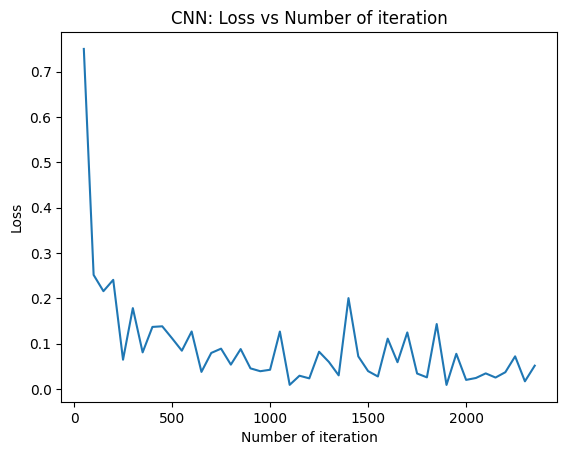

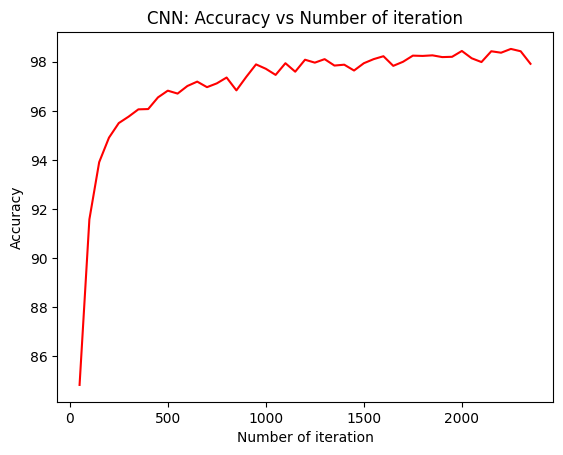

In [ ]:
# show loss and accuracy

# visualization loss
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()